# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '13'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc_snow.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2528737)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 10:06:20 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    ssi  = xr.open_dataset(fname).ssi.values
    q_i  = xr.open_dataset(fname).q_snow.values
    n_i  = xr.open_dataset(fname).n_snow.values
    # process rates
    depo = xr.open_dataset(fname).depo_snow_mass.values   
    # normalize with ssi 
    depo = np.where(ssi>1e-4,depo/ssi,np.nan)
    # values of ssi above 1e-2 are mixed-phase and at water saturation
    depo = np.where(ssi<1e-2,depo,np.nan)
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    q_i = np.log(q_i, where=q_i>q_min, out=np.nan*q_i)
    n_i = np.log(n_i, where=n_i>n_min, out=np.nan*n_i)
    depo = np.log(depo, where=depo>p_min, out=np.nan*depo)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_i, n_i, temp, ssi, rho, depo ]))
    dataset = dataset.T
    dataset.columns = [ 'q_i', 'n_i', 'temp', 'ssi', 'rho', 'depo' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_i           n_i          temp           ssi           rho  \
count  1.840088e+06  1.840088e+06  1.840088e+06  1.840088e+06  1.840088e+06   
mean  -8.666254e+00  1.081941e+01  2.424370e+02  4.161076e-03  6.972433e-01   
std    2.533980e+00  2.917546e+00  1.161929e+01  2.149977e-03  1.453490e-01   
min   -2.302575e+01 -1.446784e+01  2.066200e+02  2.000000e-04  4.270000e-01   
25%   -9.765954e+00  9.922052e+00  2.342700e+02  2.700000e-03  5.910000e-01   
50%   -8.292451e+00  1.142379e+01  2.419900e+02  3.400000e-03  6.810000e-01   
75%   -6.980807e+00  1.268324e+01  2.498100e+02  5.200000e-03  7.770000e-01   
max   -4.012064e+00  1.607404e+01  2.731500e+02  9.900000e-03  1.288000e+00   

               depo  
count  1.840088e+06  
mean  -1.398623e+01  
std    2.164342e+00  
min   -2.933405e+01  
25%   -1.487944e+01  
50%   -1.329032e+01  
75%   -1.255559e+01  
max   -6.557175e+00

### Separate in training, validation and test data

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_i       n_i        temp     ssi    rho       depo
1 -12.460861  6.875232  243.710007  0.0098  0.699 -17.621838
2 -12.225215  7.100027  243.779999  0.0098  0.700 -17.389397
3 -12.022685  7.286192  243.850006  0.0098  0.701 -17.170387
5 -11.743698  7.545390  244.000000  0.0098  0.703 -16.904375
6 -11.652694  7.640123  244.070007  0.0098  0.704 -16.808067

In [11]:
dataset_train.describe()

q_i           n_i          temp           ssi           rho  \
count  1.288364e+06  1.288364e+06  1.288364e+06  1.288364e+06  1.288364e+06   
mean  -8.665620e+00  1.081882e+01  2.424368e+02  4.160671e-03  6.972480e-01   
std    2.534648e+00  2.917968e+00  1.162113e+01  2.149624e-03  1.454008e-01   
min   -2.302525e+01 -1.435783e+01  2.066900e+02  2.000000e-04  4.270000e-01   
25%   -9.765204e+00  9.921524e+00  2.342600e+02  2.700000e-03  5.910000e-01   
50%   -8.291054e+00  1.142264e+01  2.419900e+02  3.400000e-03  6.810000e-01   
75%   -6.980409e+00  1.268429e+01  2.498100e+02  5.300000e-03  7.770000e-01   
max   -4.012064e+00  1.606964e+01  2.731500e+02  9.900000e-03  1.288000e+00   

               depo  
count  1.288364e+06  
mean  -1.398617e+01  
std    2.164597e+00  
min   -2.933405e+01  
25%   -1.487959e+01  
50%   -1.328940e+01  
75%   -1.255594e+01  
max   -6.557175e+00

In [12]:
dataset_test.describe()

q_i            n_i           temp            ssi  \
count  275857.000000  275857.000000  275857.000000  275857.000000   
mean       -8.671123      10.819235     242.425064       0.004162   
std         2.534742       2.920143      11.619180       0.002151   
min       -23.025251     -14.467842     206.619995       0.000200   
25%        -9.771424       9.917933     234.270004       0.002700   
50%        -8.300550      11.427106     241.979996       0.003400   
75%        -6.983449      12.680068     249.779999       0.005200   
max        -4.012064      16.074039     273.149994       0.009900   

                 rho           depo  
count  275857.000000  275857.000000  
mean        0.697103     -13.989532  
std         0.145295       2.165651  
min         0.428000     -28.434259  
25%         0.591000     -14.882172  
50%         0.680000     -13.295503  
75%         0.777000     -12.556396  
max         1.286000      -6.945160

In [13]:
dataset_val.describe()

q_i            n_i           temp            ssi  \
count  275867.000000  275867.000000  275867.000000  275867.000000   
mean       -8.664359      10.822332     242.450943       0.004162   
std         2.530098       2.912984      11.610843       0.002151   
min       -23.025751     -14.357827     206.830002       0.000200   
25%        -9.763265       9.927204     234.300003       0.002700   
50%        -8.291333      11.425711     242.000000       0.003400   
75%        -6.979939      12.681654     249.850006       0.005300   
max        -4.012064      16.027765     273.149994       0.009900   

                 rho           depo  
count  275867.000000  275867.000000  
mean        0.697361     -13.983188  
std         0.145161       2.161847  
min         0.428000     -28.009212  
25%         0.591000     -14.876647  
50%         0.681000     -13.289690  
75%         0.778000     -12.553317  
max         1.286000      -7.234858

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_i'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_i           n_i          temp           ssi           rho  \
count  1.279759e+06  1.279759e+06  1.279759e+06  1.279759e+06  1.279759e+06   
mean  -8.579550e+00  1.090032e+01  2.422702e+02  4.157429e-03  6.949455e-01   
std    2.313728e+00  2.750857e+00  1.147343e+01  2.146936e-03  1.429519e-01   
min   -1.999988e+01 -1.435783e+01  2.066900e+02  2.000000e-04  4.270000e-01   
25%   -9.726129e+00  9.964770e+00  2.341900e+02  2.700000e-03  5.900000e-01   
50%   -8.274090e+00  1.143902e+01  2.419000e+02  3.400000e-03  6.790000e-01   
75%   -6.969998e+00  1.269373e+01  2.496200e+02  5.200000e-03  7.750000e-01   
max   -4.012064e+00  1.606964e+01  2.731500e+02  9.900000e-03  1.279000e+00   

               depo  
count  1.279759e+06  
mean  -1.391328e+01  
std    1.978354e+00  
min   -2.703220e+01  
25%   -1.483681e+01  
50%   -1.327528e+01  
75%   -1.255133e+01  
max   -6.557175e+00

In [17]:
dataset_test.describe()

q_i            n_i           temp            ssi  \
count  273979.000000  273979.000000  273979.000000  273979.000000   
mean       -8.583632      10.902184     242.255508       0.004158   
std         2.310705       2.750466      11.468864       0.002148   
min       -19.999977     -14.467842     206.619995       0.000200   
25%        -9.732985       9.962888     234.199997       0.002700   
50%        -8.282872      11.443425     241.880005       0.003400   
75%        -6.974082      12.689085     249.580002       0.005200   
max        -4.012064      16.074039     273.149994       0.009900   

                 rho           depo  
count  273979.000000  273979.000000  
mean        0.694750     -13.915428  
std         0.142772       1.976729  
min         0.428000     -25.249998  
25%         0.590000     -14.837049  
50%         0.679000     -13.281593  
75%         0.775000     -12.551602  
max         1.286000      -6.945160

### Pairplot

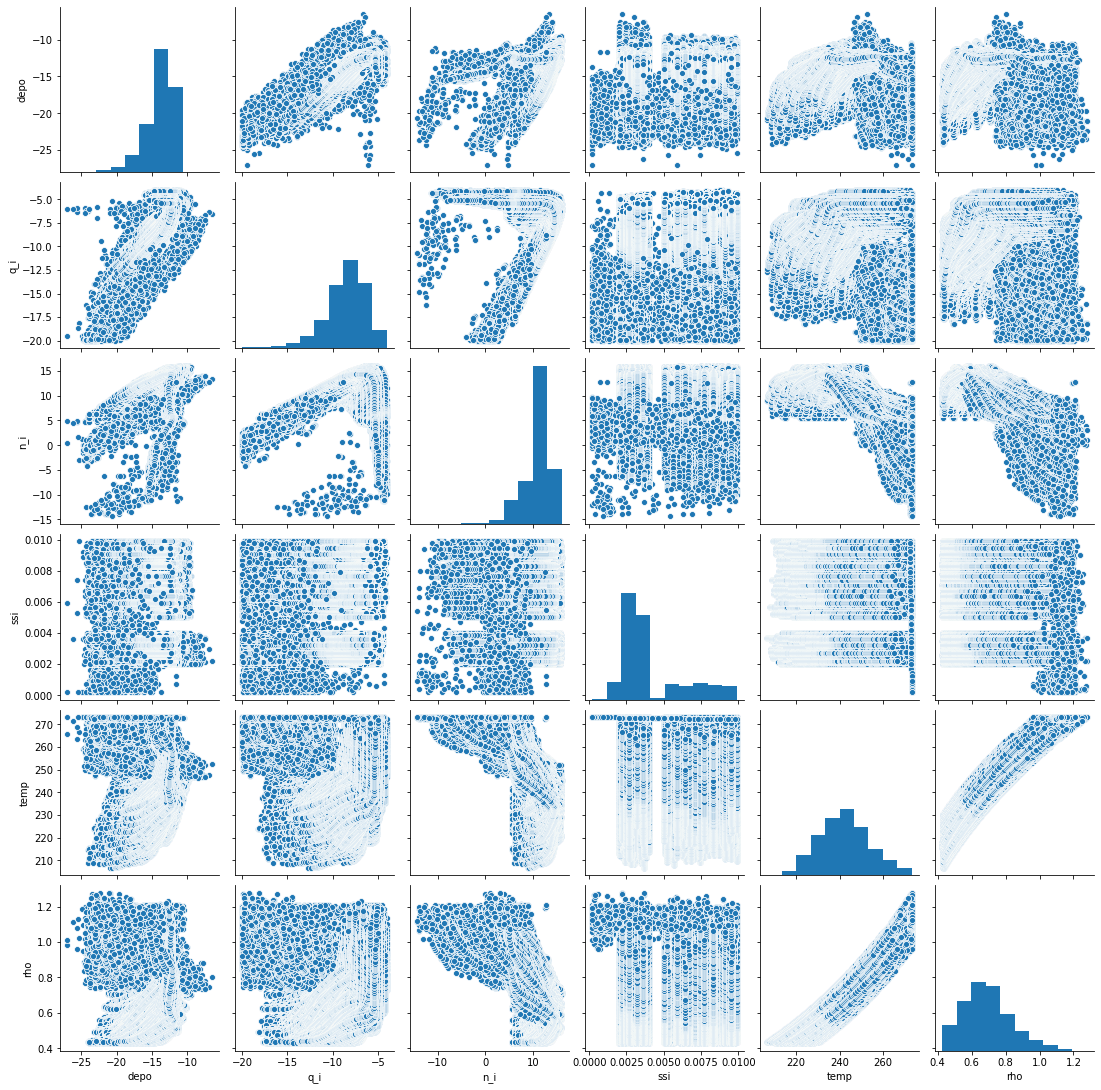

In [18]:
sns.pairplot(dataset_train[["depo","q_i","n_i","ssi","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
train_dataset2 = train_dataset2.drop(['ssi'], axis=1)
train_dataset3 = train_dataset3.drop(['ssi'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
test_dataset2 = test_dataset2.drop(['ssi'], axis=1)
test_dataset3 = test_dataset3.drop(['ssi'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
val_dataset2 = val_dataset2.drop(['ssi'], axis=1)
val_dataset3 = val_dataset3.drop(['ssi'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("depo")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min       25%       50%        75%  \
q_i  1279759.0  -8.579550  2.313728 -19.999880 -9.726129  -8.27409  -6.969998   
n_i  1279759.0  10.900323  2.750857 -14.357827  9.964770  11.43902  12.693732   

           max  
q_i  -4.012064  
n_i  16.069641

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("depo")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean        std         min         25%         50%  \
q_i   1279759.0   -8.579550   2.313728  -19.999880   -9.726129   -8.274090   
n_i   1279759.0   10.900323   2.750857  -14.357827    9.964770   11.439020   
temp  1279759.0  242.270172  11.473426  206.690002  234.190002  241.899994   
rho   1279759.0    0.694945   0.142952    0.427000    0.590000    0.679000   

             75%         max  
q_i    -6.969998   -4.012064  
n_i    12.693732   16.069641  
temp  249.619995  273.149994  
rho     0.775000    1.279000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("depo")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
q_i   1279759.0   -8.579550   2.313728  -19.999880   -9.726129   -8.274090   
n_i   1279759.0   10.900323   2.750857  -14.357827    9.964770   11.439020   
temp  1279759.0  242.270172  11.473426  206.690002  234.190002  241.899994   
rho   1279759.0    0.694945   0.142952    0.427000    0.590000    0.679000   

             75%         max  
q_i    -6.969998   -4.012064  
n_i    12.693732   16.069641  
temp  249.619995  273.149994  
rho     0.775000    1.279000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['depo']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

depo
count  1.279759e+06
mean  -1.391328e+01
std    1.978354e+00
min   -2.703220e+01
25%   -1.483681e+01
50%   -1.327528e+01
75%   -1.255133e+01
max   -6.557175e+00

In [32]:
train_dataset1.describe()

q_i           n_i
count  1.279759e+06  1.279759e+06
mean  -8.579550e+00  1.090032e+01
std    2.313728e+00  2.750857e+00
min   -1.999988e+01 -1.435783e+01
25%   -9.726129e+00  9.964770e+00
50%   -8.274090e+00  1.143902e+01
75%   -6.969998e+00  1.269373e+01
max   -4.012064e+00  1.606964e+01

In [33]:
train_dataset2.describe()

q_i           n_i          temp           rho
count  1.279759e+06  1.279759e+06  1.279759e+06  1.279759e+06
mean  -8.579550e+00  1.090032e+01  2.422702e+02  6.949455e-01
std    2.313728e+00  2.750857e+00  1.147343e+01  1.429519e-01
min   -1.999988e+01 -1.435783e+01  2.066900e+02  4.270000e-01
25%   -9.726129e+00  9.964770e+00  2.341900e+02  5.900000e-01
50%   -8.274090e+00  1.143902e+01  2.419000e+02  6.790000e-01
75%   -6.969998e+00  1.269373e+01  2.496200e+02  7.750000e-01
max   -4.012064e+00  1.606964e+01  2.731500e+02  1.279000e+00

In [34]:
train_dataset3.describe()

q_i           n_i          temp           rho
count  1.279759e+06  1.279759e+06  1.279759e+06  1.279759e+06
mean  -8.579550e+00  1.090032e+01  2.422702e+02  6.949455e-01
std    2.313728e+00  2.750857e+00  1.147343e+01  1.429519e-01
min   -1.999988e+01 -1.435783e+01  2.066900e+02  4.270000e-01
25%   -9.726129e+00  9.964770e+00  2.341900e+02  5.900000e-01
50%   -8.274090e+00  1.143902e+01  2.419000e+02  6.790000e-01
75%   -6.969998e+00  1.269373e+01  2.496200e+02  7.750000e-01
max   -4.012064e+00  1.606964e+01  2.731500e+02  1.279000e+00

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std      min       25%       50%       75%  \
q_i  1279759.0 -4.253327e-07  1.0 -4.93590 -0.495555  0.132021  0.695653   
n_i  1279759.0  5.331570e-07  1.0 -9.18192 -0.340095  0.195829  0.651946   

          max  
q_i  1.974081  
n_i  1.879166

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_i   1279759.0 -4.253327e-07  1.0 -4.935900 -0.495555  0.132021  0.695653   
n_i   1279759.0  5.331570e-07  1.0 -9.181920 -0.340095  0.195829  0.651946   
temp  1279759.0 -6.633353e-07  1.0 -3.101094 -0.704251 -0.032264  0.640595   
rho   1279759.0  7.709533e-07  1.0 -1.874376 -0.734132 -0.111544  0.560010   

           max  
q_i   1.974081  
n_i   1.879166  
temp  2.691421  
rho   4.085673

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_i   1279759.0 -4.253327e-07  1.0 -4.935900 -0.495555  0.132021  0.695653   
n_i   1279759.0  5.331570e-07  1.0 -9.181920 -0.340095  0.195829  0.651946   
temp  1279759.0 -6.633353e-07  1.0 -3.101094 -0.704251 -0.032264  0.640595   
rho   1279759.0  7.709533e-07  1.0 -1.874376 -0.734132 -0.111544  0.560010   

           max  
q_i   1.974081  
n_i   1.879166  
temp  2.691421  
rho   4.085673

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
depo  1279759.0 -13.913282  1.978354 -27.032204 -14.836811 -13.275284   

           75%       max  
depo -12.55133 -6.557175

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "ReLU"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(2,8,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.14882545],
       [-0.13911662],
       [-0.13053016],
       [-0.11879699],
       [-0.11531983],
       [-0.10839671],
       [-0.10443822],
       [-0.09923436],
       [-0.09242024],
       [-0.09005985]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
nsize = 2
activ = "ReLU_Adam"
model1 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0282,  mae:0.0813,  mse:0.0282,  val_loss:0.0131,  val_mae:0.0708,  val_mse:0.0131,  
........................

Text(0, 0.5, 'MAE')

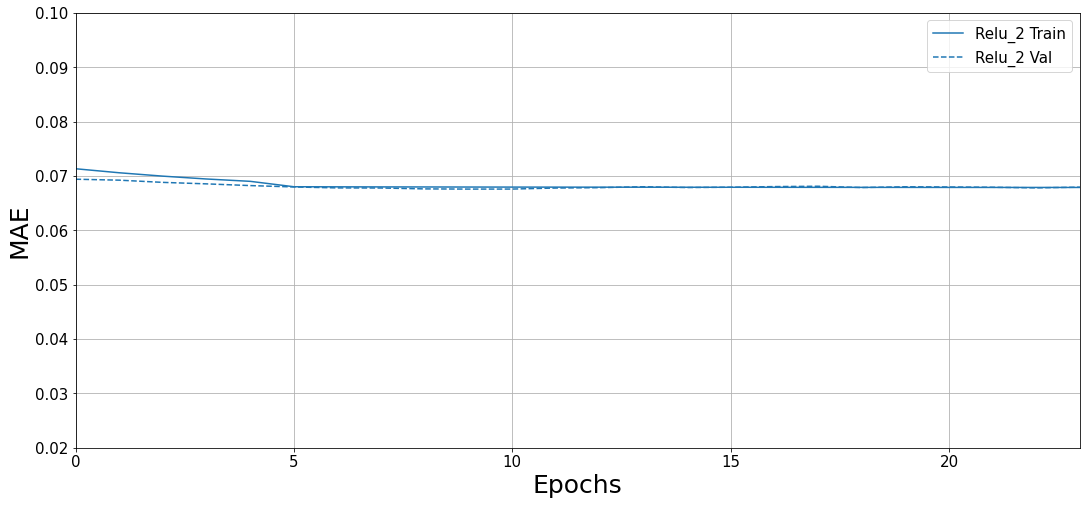

In [47]:
histories['ReLU_2'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.1])
plt.ylabel('MAE')

In [48]:
nsize = 4
activ = "ReLU_Adam"
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0134,  mae:0.0611,  mse:0.0134,  val_loss:0.0100,  val_mae:0.0481,  val_mse:0.0100,  
............

Text(0, 0.5, 'MAE')

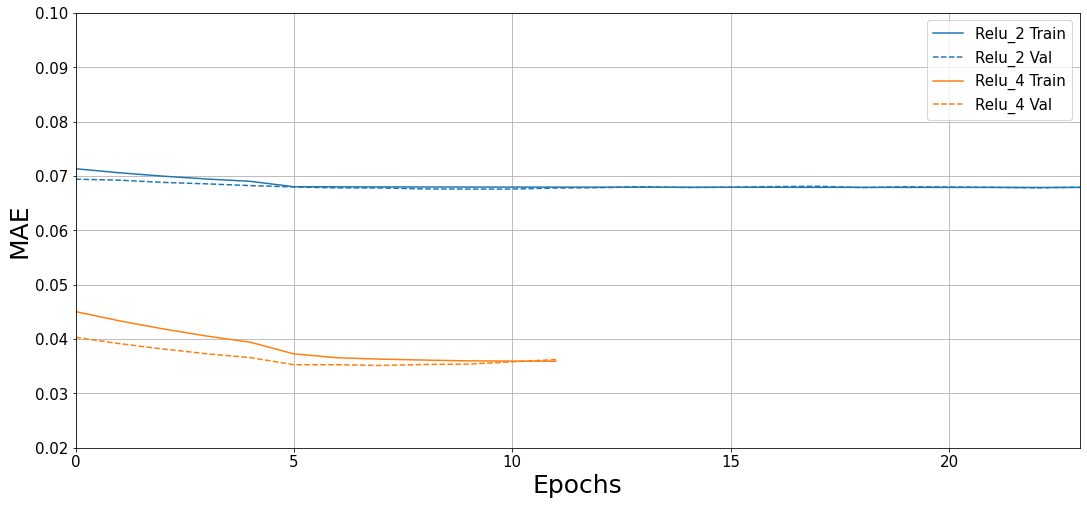

In [49]:
histories['ReLU_4'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.10])
plt.ylabel('MAE')

In [50]:
nsize = 6
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0128,  mae:0.0457,  mse:0.0128,  val_loss:0.0063,  val_mae:0.0352,  val_mse:0.0063,  
...........

Text(0, 0.5, 'MAE')

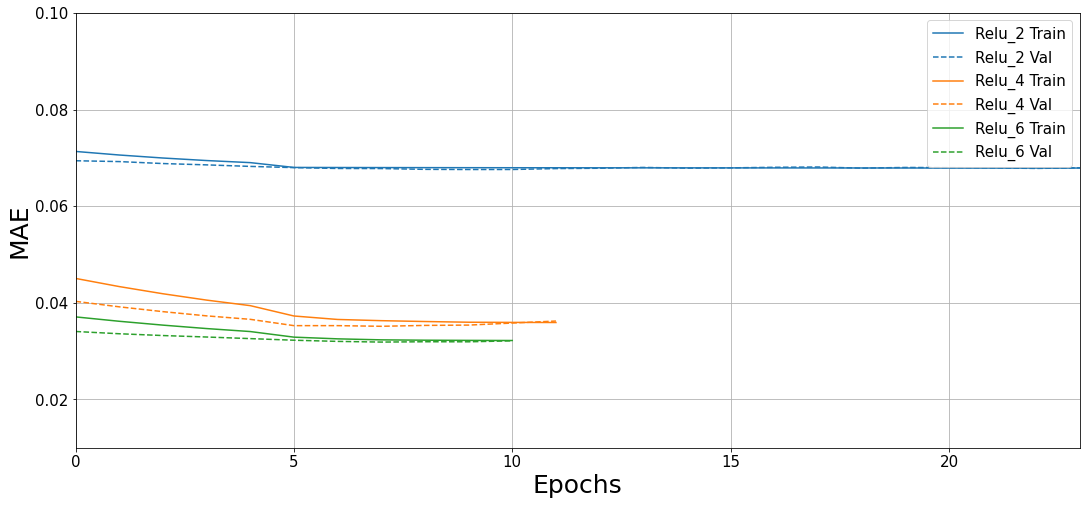

In [51]:
histories['ReLU_6'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.01, 0.10])
plt.ylabel('MAE')

In [52]:
nsize = 8
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0120,  mae:0.0442,  mse:0.0120,  val_loss:0.0061,  val_mae:0.0321,  val_mse:0.0061,  
...................

Text(0, 0.5, 'MAE')

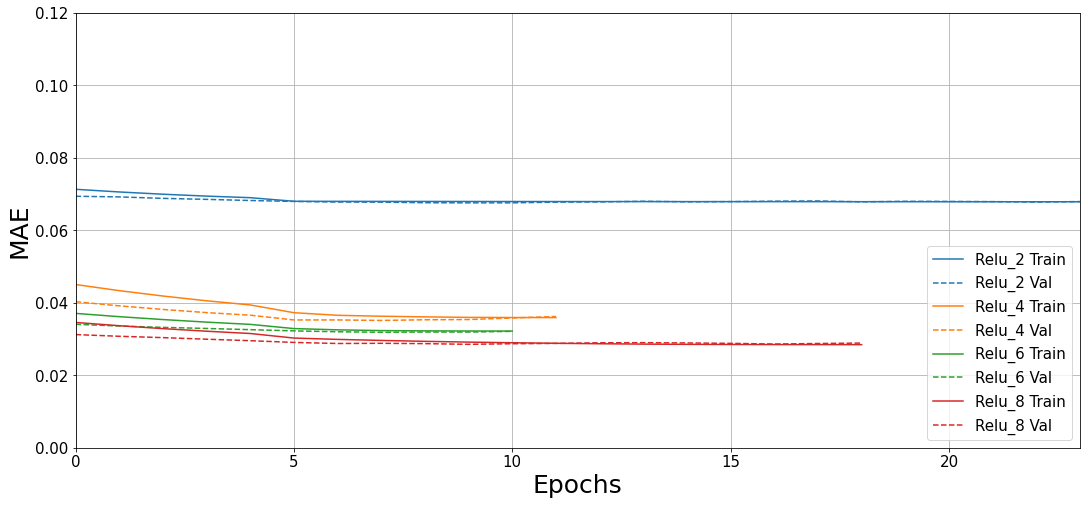

In [53]:
histories['ReLU_8'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.12])
plt.ylabel('MAE')

In [54]:
nsize = 16
model5 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0079,  mae:0.0372,  mse:0.0079,  val_loss:0.0057,  val_mae:0.0284,  val_mse:0.0057,  
...........

Text(0, 0.5, 'MAE')

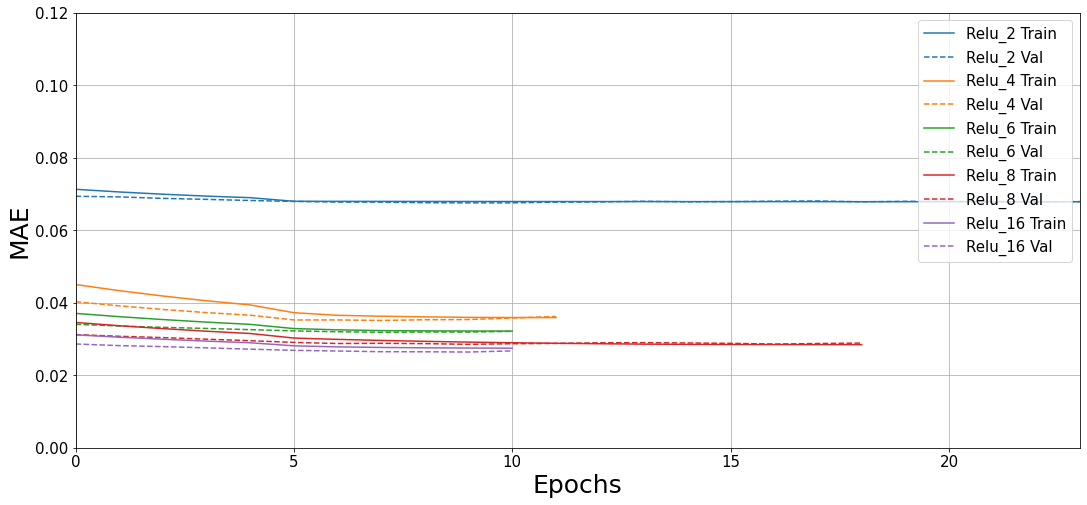

In [55]:
histories['ReLU_16'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.12])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

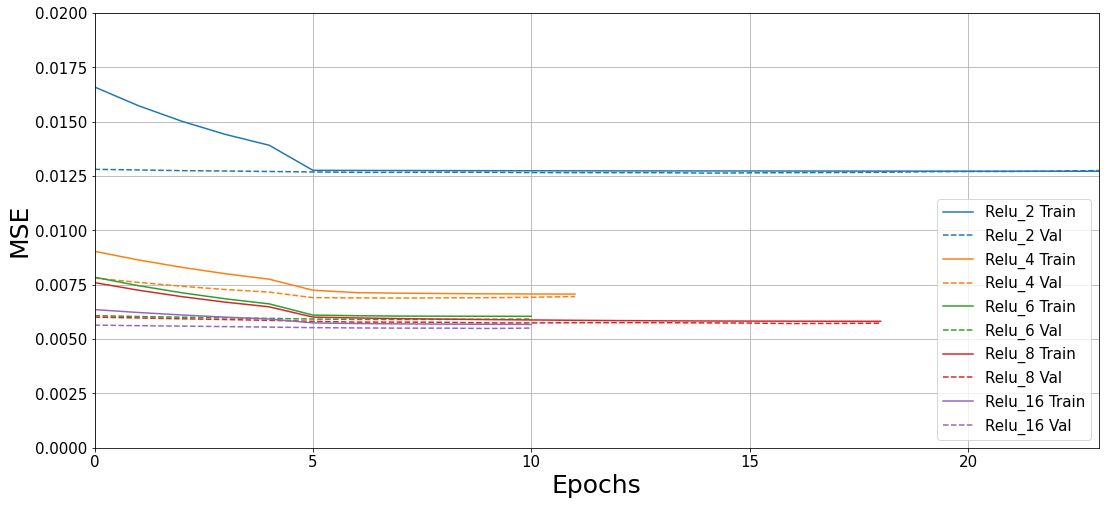

In [57]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.0, 0.02])
plt.ylabel('MSE')

In [58]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:20.5f}".format(mae1))

273979/273979 - 6s - loss: 0.0125 - mae: 0.0666 - mse: 0.0125
Testing set for model 1, Mean Abs Error:              0.06661


In [59]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

273979/273979 - 6s - loss: 0.0068 - mae: 0.0335 - mse: 0.0068
Testing set for model 2, Mean Abs Error:              0.03345


In [60]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

273979/273979 - 6s - loss: 0.0059 - mae: 0.0307 - mse: 0.0059
Testing set for model 3, Mean Abs Error:              0.03067


In [61]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

273979/273979 - 6s - loss: 0.0057 - mae: 0.0275 - mse: 0.0057
Testing set for model 4, Mean Abs Error:              0.02748


In [62]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

273979/273979 - 6s - loss: 0.0055 - mae: 0.0246 - mse: 0.0055
Testing set for model 5, Mean Abs Error:              0.02461


In [63]:
mae = [ mae1, mae2, mae3, mae4, mae5 ]
mae

[0.06660669, 0.03345058, 0.030666413, 0.027477613, 0.024607822]

In [64]:
mse = [ mse2, mse2, mse3, mse4, mse5 ]
mse

[0.006793936, 0.006793936, 0.0059281955, 0.0056645675, 0.005485482]

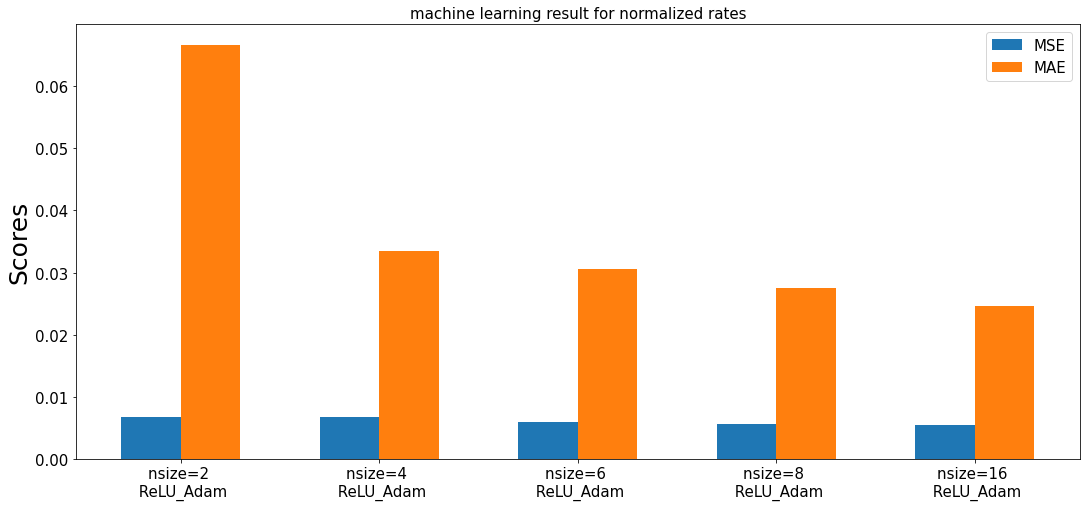

In [65]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'nsize=2 \n ReLU_Adam',
 'nsize=4 \n ReLU_Adam',
 'nsize=6 \n ReLU_Adam',
 'nsize=8 \n ReLU_Adam',
 'nsize=16 \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [66]:
test_true_mass  = np.exp(test_labels.pop('depo'))

In [67]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [68]:
labels = [ "depo" ]

p1 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=labels)

In [69]:
test_predict1 = backtransform(p1,train_labels_stats)

In [70]:
test_predict1_mass  = np.exp(test_predict1['depo'])

In [71]:
p2 = pd.DataFrame(data=model3.predict(normed_test_data2), columns=labels)

test_predict2 = backtransform(p2,train_labels_stats)

test_predict2_mass  = np.exp(test_predict2['depo'])

In [72]:
p4 = pd.DataFrame(data=model4.predict(normed_test_data2), columns=labels)
test_predict4 = backtransform(p4,train_labels_stats)
test_predict4_mass  = np.exp(test_predict4['depo'])

In [73]:
p5 = pd.DataFrame(data=model5.predict(normed_test_data2), columns=labels)
test_predict5 = backtransform(p5,train_labels_stats)
test_predict5_mass  = np.exp(test_predict5['depo'])

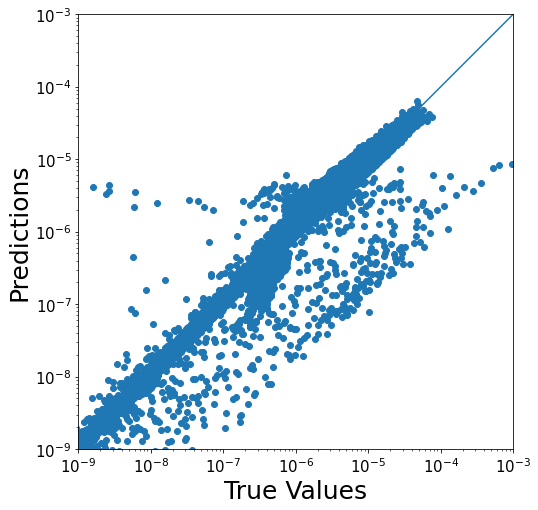

In [74]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-9, 1e-3
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

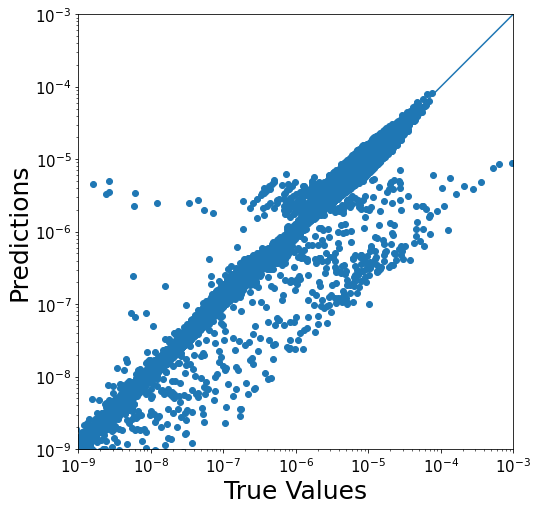

In [75]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict4_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

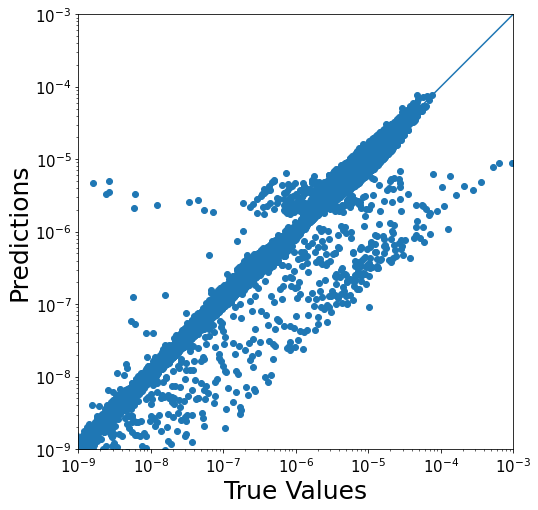

In [76]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict5_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [77]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
version

'13'

In [78]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, labels_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["out_logtransform"] = xr.DataArray(labels_ltf, dims=("Nout_{}".format(nout)))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [79]:
labels   = 'depo_snow_mass'
logtransformOutput = np.array([True], dtype=bool)

features = 'q_snow, n_snow, T, rho'
logtransformInput = np.array([True, True, False, False], dtype=bool)

filename = 'saved_model_v2/depo_snow_model1_'+version+'.nc'
save2netcdf(model1,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)
filename = 'saved_model_v2/depo_snow_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)
filename = 'saved_model_v2/depo_snow_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)
filename = 'saved_model_v2/depo_snow_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)
filename = 'saved_model_v2/depo_snow_model5_'+version+'.nc'
save2netcdf(model5,features,labels,train_stats2,train_labels_stats,logtransformInput,logtransformOutput,filename)


Saving model to saved_model_v2/depo_snow_model1_13.nc
  Features:   q_snow, n_snow, T, rho
  Labels:     depo_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 2), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (2, 2), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (2, 1), Activation: linear
Saving model to saved_model_v2/depo_snow_model2_13.nc
  Features:   q_snow, n_snow, T, rho
  Labels:     depo_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 4), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 4), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 1), Activation: linear
Saving model to saved_model_v2/depo_snow_model3_13.nc
  Features:   q_snow, n_snow, T, rho
  Labels:     depo_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 6), Activation: relu
  Layer 1: <c